## *Análisis del Dataset de insuficiencia cardiaca* heart_failure_clinical_records_dataset.csv de Kaggle

### **Presentado por:**

Angélica Órtiz Álvarez (aortiz016@soyudemedellin.edu.co)

Jhon Jader Diaz Gomez (jdiaz510@soyudemedellin.edu.co)

Cristian Camilo Ospina Metaute (cospina149@soyudemedellin.edu.co)

### Para iniciar, se importan las librerías requeridas para manipulación de datos y manejo de modelos

In [1]:
import numpy as np 
import pandas as pd
import random
import re
import os
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix

### Posteriormente, se carga el dataset heart_failure_clinical_records_dataset.csv de [Kaggle](https://www.kaggle.com/code/arjunamla02/logistic-regession-vs-decision-tree-vs-rf/notebook) - [UCI Irvine](https://archive.ics.uci.edu/dataset/519/heart+failure+clinical+records)


In [2]:
# Buscar la carpeta raíz del proyecto por nombre
carpeta_actual = os.getcwd()
nombre_proyecto = "ProyectoCienciaDatos"

# Recorrer hacia arriba hasta encontrar la carpeta raíz
while os.path.basename(carpeta_actual) != nombre_proyecto:
    carpeta_actual = os.path.dirname(carpeta_actual)
    if carpeta_actual == os.path.dirname(carpeta_actual):  # Llegamos al tope
        raise FileNotFoundError(f"No se encontró la carpeta raíz '{nombre_proyecto}'.")

# Construir la ruta al archivo CSV
ruta_csv = os.path.join(carpeta_actual, "data", "raw", "heart_failure_clinical_records_dataset.csv")

# Leer el archivo
df = pd.read_csv(ruta_csv)
df.head()  


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


### Se imprime el resumen de la estructura del DataFrame, con el objetivo de inspeccionar los datos.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


### **Nota:** Debido a que la base de datos original tiene solo 299 registros, se simula 2000  datos adicionales para obtener un total de 2.299, de manera que se tenga una base de datos más robusta y con ruido, para hacer el ejercicio de manipulación de datos.

### **Definiciones y carga de datos**


In [4]:
# Definición de las columnas y sus tipos de datos esperados
columns = [
    'age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
    'ejection_fraction', 'high_blood_pressure', 'platelets',
    'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time',
    'DEATH_EVENT'
]

# Rango de valores (aproximados, basados en el dataset original) para la generación sintética
# Usaremos estos rangos para "recortar" (clip) los valores generados por el GMM y asegurar que sean realistas.
data_ranges = {
    'age': (40, 95),
    'anaemia': (0, 1), # Binario
    'creatinine_phosphokinase': (23, 7861), 
    'diabetes': (0, 1), # Binario
    'ejection_fraction': (14, 80),
    'high_blood_pressure': (0, 1), # Binario
    'platelets': (25100, 850000), # Ajustado ligeramente basado en .describe() de datos reales
    'serum_creatinine': (0.5, 9.4),
    'serum_sodium': (113, 148),
    'sex': (0, 1), # Binario
    'smoking': (0, 1), # Binario
    'time': (4, 285),
    'DEATH_EVENT': (0, 1) # Binario
}

try:
    df_original = df.copy()
    print(f"Dataset original heart_failure_clinical_records_dataset.csv cargado. Contiene {len(df_original)} filas.")
    # Asegurarnos que las columnas del original coinciden
    df_original = df_original[columns]
except Exception as e:
    print(f"Error al cargar el archivo original: {e}")
    # Salir si no podemos cargar el archivo base
    exit()

# --- 1. Generación de Datos Sintéticos (con Correlaciones) ---

# Número de nuevos registros a crear
n_new_records = 2000

# Inicializar el Modelo de Mezcla Gaussiana (GMM)
# Usamos n_components=5 para capturar diferentes "perfiles" de pacientes en los datos
# Usamos covariance_type='full' para capturar las correlaciones completas entre todas las características
gmm = GaussianMixture(n_components=5, random_state=42, covariance_type='full', max_iter=200, n_init=5)

# Entrenar el GMM con los datos originales
print("Entrenando modelo GMM en los datos originales...")
gmm.fit(df_original)

# Generar 2000 nuevas muestras a partir del modelo entrenado
print(f"Generando {n_new_records} nuevos registros sintéticos...")
new_data_array, _ = gmm.sample(n_samples=n_new_records)

# Convertir las muestras en un DataFrame
df_synthetic = pd.DataFrame(new_data_array, columns=columns)

# --- 2. Post-procesamiento de los Datos Sintéticos ---
# El GMM genera valores flotantes para todas las columnas.
# Necesitamos redondearlos, recortarlos (clip) a rangos realistas y convertirlos a sus tipos de datos correctos.

print("Post-procesando los datos sintéticos (redondeo, recorte y tipos de datos)...")

for col in columns:
    min_val, max_val = data_ranges[col]

    if col in ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking', 'DEATH_EVENT']:
        # Columnas binarias
        df_synthetic[col] = np.round(df_synthetic[col])
        df_synthetic[col] = np.clip(df_synthetic[col], min_val, max_val)
        df_synthetic[col] = df_synthetic[col].astype(int)
        
    elif col in ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'time', 'serum_sodium']:
        # Columnas enteras (incluimos serum_sodium basado en el df.info() original)
        df_synthetic[col] = np.round(df_synthetic[col])
        df_synthetic[col] = np.clip(df_synthetic[col], min_val, max_val)
        df_synthetic[col] = df_synthetic[col].astype(int)
        
    elif col in ['platelets', 'serum_creatinine']:
        # Columnas flotantes
        df_synthetic[col] = np.clip(df_synthetic[col], min_val, max_val)
        df_synthetic[col] = np.round(df_synthetic[col], 2) # Redondear a 2 decimales

print("\n--- Primeras 5 filas de datos sintéticos (limpios, antes de errores) ---")
print(df_synthetic.head())

# --- 3. Introducción de Errores (siguiendo la estrategia del script) ---
# Aplicamos la misma lógica de errores del script proporcionado, pero ÚNICAMENTE
# al nuevo DataFrame 'df_synthetic'.

print(f"Introduciendo errores y valores nulos en los {n_new_records} registros sintéticos...")

# 1. VALORES NULOS (NaN)
np.random.seed(43) # Nueva semilla
null_cols = ['age', 'creatinine_phosphokinase', 'platelets', 'serum_creatinine', 'DEATH_EVENT']

for col in null_cols:
    nan_count = int(n_new_records * random.uniform(0.05, 0.15))
    # Asegurarse de que los índices existan en df_synthetic (de 0 a n_new_records-1)
    nan_indices = np.random.choice(df_synthetic.index, nan_count, replace=False)
    df_synthetic.loc[nan_indices, col] = np.nan

# 2. CAMBIOS EN EL TIPO DE DATO (para forzar conversión o limpieza)

# a) Conversión de 'sex' a Texto ('MALE'/'FEMALE')
string_conversion_count = int(n_new_records * 0.10)
string_indices = np.random.choice(df_synthetic.index, string_conversion_count, replace=False)

for i in string_indices:
    if df_synthetic.loc[i, 'sex'] == 1:
        df_synthetic.loc[i, 'sex'] = random.choice(['MALE', 'male'])
    else:
        df_synthetic.loc[i, 'sex'] = random.choice(['FEMALE', 'female'])

# b) Conversión de 'serum_creatinine' a Texto con unidades
string_unit_count = int(n_new_records * 0.08)
string_unit_indices = np.random.choice(df_synthetic.index, string_unit_count, replace=False)

for i in string_unit_indices:
    original_value = df_synthetic.loc[i, 'serum_creatinine']
    if not pd.isna(original_value): # No modificar si ya es NaN
        df_synthetic.loc[i, 'serum_creatinine'] = f"{original_value:.2f} mg/dL"
    else:
        # Si era NaN por el paso anterior, podemos asignarle otro valor no numérico
        if random.random() < 0.5:
            df_synthetic.loc[i, 'serum_creatinine'] = 'Desconocido'

# c) Valores inconsistentes para 'diabetes'
inconsistent_count = int(n_new_records * 0.12)
inconsistent_indices = np.random.choice(df_synthetic.index, inconsistent_count, replace=False)

for i in inconsistent_indices:
    if df_synthetic.loc[i, 'diabetes'] == 1:
        df_synthetic.loc[i, 'diabetes'] = random.choice(['YES', 2])
    else:
        df_synthetic.loc[i, 'diabetes'] = random.choice(['NO', 'N/A', 0])

# d) Valores extremos en 'ejection_fraction'
extreme_count = int(n_new_records * 0.04)
extreme_indices = np.random.choice(df_synthetic.index, extreme_count, replace=False)
for i in extreme_indices:
    df_synthetic.loc[i, 'ejection_fraction'] = random.choice([-1, 999])

print("Introducción de errores completada.")

# --- 4. Combinar y Guardar ---

# Concatenar el DataFrame original (limpio) y los nuevos registros sintéticos (con errores)
df_final = pd.concat([df_original, df_synthetic], ignore_index=True)

# Reordenar las columnas para asegurar el formato original
df_final = df_final[columns]

df = df_final.copy()

Dataset original heart_failure_clinical_records_dataset.csv cargado. Contiene 299 filas.
Entrenando modelo GMM en los datos originales...
Generando 2000 nuevos registros sintéticos...
Post-procesando los datos sintéticos (redondeo, recorte y tipos de datos)...

--- Primeras 5 filas de datos sintéticos (limpios, antes de errores) ---
   age  anaemia  creatinine_phosphokinase  diabetes  ejection_fraction  \
0   60        0                       591         0                 55   
1   56        0                      5738         0                 43   
2   66        1                      2117         0                 14   
3   63        0                        23         0                 23   
4   54        1                        23         1                 41   

   high_blood_pressure  platelets  serum_creatinine  serum_sodium  sex  \
0                    1  277875.38              1.52           148    0   
1                    0  235014.28              0.50           138    1  

C:\Users\geli9\AppData\Local\Temp\ipykernel_18484\1293082597.py:111: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'male' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_synthetic.loc[i, 'sex'] = random.choice(['MALE', 'male'])
C:\Users\geli9\AppData\Local\Temp\ipykernel_18484\1293082597.py:122: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.09 mg/dL' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_synthetic.loc[i, 'serum_creatinine'] = f"{original_value:.2f} mg/dL"
C:\Users\geli9\AppData\Local\Temp\ipykernel_18484\1293082597.py:134: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'YES' has dtype incompatible with int64, please explicitly cast to a compati

### **Exploración Rápida de Datos (EDA)**

In [5]:
print("Shape:", df.shape)
print("\nColumnas:", df.columns.tolist())
print("\nInfo:")
display(df.info())

print("\nDescripción numérica:")
display(df.describe().T)

Shape: (2299, 13)

Columnas: ['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes', 'ejection_fraction', 'high_blood_pressure', 'platelets', 'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time', 'DEATH_EVENT']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2299 entries, 0 to 2298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       2014 non-null   float64
 1   anaemia                   2299 non-null   int64  
 2   creatinine_phosphokinase  2043 non-null   float64
 3   diabetes                  2299 non-null   object 
 4   ejection_fraction         2299 non-null   int64  
 5   high_blood_pressure       2299 non-null   int64  
 6   platelets                 2038 non-null   float64
 7   serum_creatinine          2013 non-null   object 
 8   serum_sodium              2299 non-null   int64  
 9   sex                       2299 non-null   object 
 10 

None


Descripción numérica:


,count,mean,std,min,25%,50%,75%,max
age,2014.0,60.874545,11.441041,40.0,53.0000,60.000,69.00,95.0
anaemia,2299.0,0.461505,0.498624,0.0,0.0000,0.000,1.00,1.0
creatinine_phosphokinase,2043.0,601.518845,865.601516,23.0,118.0000,338.000,624.00,7861.0
ejection_fraction,2299.0,55.794258,130.854050,-1.0,30.0000,38.000,47.00,999.0
high_blood_pressure,2299.0,0.367986,0.482362,0.0,0.0000,0.000,1.00,1.0
platelets,2038.0,264153.475913,99006.931064,25100.0,207729.6675,259381.625,306844.65,850000.0
serum_sodium,2299.0,136.700304,4.285935,113.0,134.0000,137.000,140.00,148.0
smoking,2299.0,0.346672,0.476014,0.0,0.0000,0.000,1.00,1.0
time,2299.0,132.355807,73.406486,4.0,76.0000,130.000,187.00,285.0
DEATH_EVENT,2077.0,0.318247,0.465908,0.0,0.0000,0.000,1.00,1.0


In [6]:
# Tipos, nulos, valores únicos
print("Tipos de datos:")
display(df.dtypes)
print("\nValores nulos por columna:")
display(df.isnull().sum())
print("\nConteos únicos por columna (hasta 10 mostrados):")
display(df.nunique().sort_values(ascending=False).head(20))

# Asegurar que la columna target está presente y es entera
target_col = "DEATH_EVENT"
if target_col not in df.columns:
    raise KeyError(f"No se encontró la columna objetivo '{target_col}' en el dataset.")
df[target_col] = pd.to_numeric(df[target_col], errors="coerce").astype("Int64")
print(f"\nDistribución de {target_col}:")
display(df[target_col].value_counts(dropna=False))

# Corregir posibles columnas numéricas mal tipadas (por ejemplo ages con float)
for c in df.columns:
    if df[c].dtype == "float64" and df[c].dropna().apply(float.is_integer).all():
        # si son floats que representan enteros, convertir a int
        df[c] = df[c].astype("Int64")

Tipos de datos:


age                         float64
anaemia                       int64
creatinine_phosphokinase    float64
diabetes                     object
ejection_fraction             int64
high_blood_pressure           int64
platelets                   float64
serum_creatinine             object
serum_sodium                  int64
sex                          object
smoking                       int64
time                          int64
DEATH_EVENT                 float64
dtype: object


Valores nulos por columna:


age                         285
anaemia                       0
creatinine_phosphokinase    256
diabetes                      0
ejection_fraction             0
high_blood_pressure           0
platelets                   261
serum_creatinine            286
serum_sodium                  0
sex                           0
smoking                       0
time                          0
DEATH_EVENT                 222
dtype: int64


Conteos únicos por columna (hasta 10 mostrados):


platelets                   1910
creatinine_phosphokinase     968
serum_creatinine             411
time                         281
ejection_fraction             65
age                           57
serum_sodium                  32
sex                            6
diabetes                       6
anaemia                        2
high_blood_pressure            2
smoking                        2
DEATH_EVENT                    2
dtype: int64


Distribución de DEATH_EVENT:


DEATH_EVENT
0       1416
1        661
<NA>     222
Name: count, dtype: Int64

### Después de hacer la exploración inicial, identificamos lo siguiente:
- Hay 13 columnas y 2299 registros. 
- Las columnas `age`, ``creatinine``, ``platelets``, ``serum_cretinine`` y ``Death_event`` tienen nulos y los tipos de datos son númericos y objetos
- De las 13 columnas existentes, hay 6 columnas booleanas que indican si se da o no esa situación: ``diabetes``, ``anaemia``, ``high_blood_pressure``, ``sex``, ``smoking``, ``DEATH_EVENT``

### **Preprocesamiento inicial de datos**
### Se eliminan los registros nulos de la variable objetivo ``Death_event`` debido a que consideramos que es un valor relevante para la predicción

In [7]:
df.dropna(subset=['DEATH_EVENT'], inplace=True)
print("\nValores nulos por columna:")
display(df.isnull().sum())


Valores nulos por columna:


age                         247
anaemia                       0
creatinine_phosphokinase    223
diabetes                      0
ejection_fraction             0
high_blood_pressure           0
platelets                   234
serum_creatinine            252
serum_sodium                  0
sex                           0
smoking                       0
time                          0
DEATH_EVENT                   0
dtype: int64

In [8]:
# Reemplaza la celda incompleta por el siguiente código:
for col in df.columns:
    print(f"\n=== Columna: {col} ===")
    # Tipos por elemento
    tipos = df[col].apply(type).value_counts()
    print("Tipos por elemento:")
    print(tipos.to_dict())



=== Columna: age ===
Tipos por elemento:
{<class 'float'>: 2077}

=== Columna: anaemia ===
Tipos por elemento:
{<class 'int'>: 2077}

=== Columna: creatinine_phosphokinase ===
Tipos por elemento:
{<class 'float'>: 2077}

=== Columna: diabetes ===
Tipos por elemento:
{<class 'int'>: 1949, <class 'str'>: 128}

=== Columna: ejection_fraction ===
Tipos por elemento:
{<class 'int'>: 2077}

=== Columna: high_blood_pressure ===
Tipos por elemento:
{<class 'int'>: 2077}

=== Columna: platelets ===
Tipos por elemento:
{<class 'float'>: 2077}

=== Columna: serum_creatinine ===
Tipos por elemento:
{<class 'float'>: 1949, <class 'str'>: 128}

=== Columna: serum_sodium ===
Tipos por elemento:
{<class 'int'>: 2077}

=== Columna: sex ===
Tipos por elemento:
{<class 'int'>: 1903, <class 'str'>: 174}

=== Columna: smoking ===
Tipos por elemento:
{<class 'int'>: 2077}

=== Columna: time ===
Tipos por elemento:
{<class 'int'>: 2077}

=== Columna: DEATH_EVENT ===
Tipos por elemento:
{<class 'int'>: 2077}

### De la revisión anterior, se identifica que las columnas `serum_creatinine`, `sex` y `diabetes` tienen valores que son de tipo *string*, cuando se espera que sean todos numéricos, por lo que se realiza un procesamiento especial para estas columnas.

### **Transformación y limpieza de la columna `serum_creatine`**

### Este proceso tiene como objetivo estandarizar los datos de la columna `serum_creatine` a un tipo booleano, identificando y transformando los valores de texto y gestionando los valores nulos.

In [9]:
strings_serum_creatinine = df['serum_creatinine'][df['serum_creatinine'].apply(lambda x: isinstance(x, str))]
strings_serum_creatinine

302     1.18 mg/dL
314     2.69 mg/dL
320     2.97 mg/dL
344     0.50 mg/dL
371     2.22 mg/dL
           ...    
2276    1.49 mg/dL
2283    1.14 mg/dL
2285    1.04 mg/dL
2290    1.74 mg/dL
2295    1.26 mg/dL
Name: serum_creatinine, Length: 128, dtype: object

In [10]:
def clean_serum_creatinine(v):
    if pd.isna(v):
        return np.nan
    if isinstance(v, str):
        s = v.strip()
        if s.lower() == 'desconocido':
            return np.nan
        s = s.replace(',', '.')
        m = re.search(r'[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?', s)
        return float(m.group()) if m else np.nan
    try:
        return float(v)
    except Exception:
        return np.nan

df['serum_creatinine'] = df['serum_creatinine'].apply(clean_serum_creatinine)
df['serum_creatinine'] = pd.to_numeric(df['serum_creatinine'], errors='coerce')

print("\nResumen post-limpieza serum_creatinine:")
print(df['serum_creatinine'].describe())
print("Nulos en serum_creatinine:", df['serum_creatinine'].isna().sum())


Resumen post-limpieza serum_creatinine:
count    1815.000000
mean        1.407791
std         0.961030
min         0.500000
25%         0.900000
50%         1.130000
75%         1.500000
max         9.400000
Name: serum_creatinine, dtype: float64
Nulos en serum_creatinine: 262


### **Transformación y limpieza de la columna `sex`**

### Este proceso tiene como objetivo estandarizar los datos de la columna `sex` a un tipo booleano, identificando y transformando los valores de texto y gestionando los valores nulos (NaN).

In [11]:
strings_sex = df['sex'][df['sex'].apply(lambda x: isinstance(x, str))]
strings_sex

314       male
332     female
333       MALE
339       MALE
346       MALE
         ...  
2233      male
2234    FEMALE
2239      male
2248    female
2261      MALE
Name: sex, Length: 174, dtype: object

In [12]:
df['sex'].unique()

array([1, 0, 'male', 'female', 'MALE', 'FEMALE'], dtype=object)

In [13]:
def clean_sex(v):
    if isinstance(v, str):
        s = v.lower()
        if s in ('male'):
            return 1
        if s in ('female'):
            return 0
    else:
        return v

df['sex'] = df['sex'].apply(clean_sex)

print("\nConteos en 'sex' después de la limpieza (incluye NA):")
display(df['sex'].value_counts(dropna=False))



Conteos en 'sex' después de la limpieza (incluye NA):


sex
1    1306
0     771
Name: count, dtype: int64

### **Transformación y limpieza de la columna `diabetes`**

### Este proceso tiene como objetivo estandarizar los datos de la columna `diabetes` a un tipo booleano, identificando y transformando los valores de texto y gestionando los valores nulos (NaN).

In [14]:
df['diabetes'].unique()

array([0, 1, 'NO', 'N/A', 'YES', 2], dtype=object)

In [15]:
strings_diabetes = df['diabetes'][df['diabetes'].apply(lambda x: isinstance(x, str))]
strings_diabetes

299      NO
300     N/A
304     YES
328      NO
338     N/A
       ... 
2199    N/A
2201    YES
2221    N/A
2280    YES
2290    YES
Name: diabetes, Length: 128, dtype: object

In [16]:
def clean_diabetes(v):
    if isinstance(v, str):
        s = v.lower()
        if s in ('yes'):
            return 1
        if s in ('no'):
            return 0
        if s in ('n/a'):
            return np.nan
    elif v == 2:
        return np.nan
    else:
        return v

df['diabetes'] = df['diabetes'].apply(clean_diabetes).astype('Int64')


print("\nConteos en 'diabetes' después de la limpieza (incluye NA):")
display(df['diabetes'].value_counts(dropna=False))


Conteos en 'diabetes' después de la limpieza (incluye NA):


diabetes
0       1163
1        816
<NA>      98
Name: count, dtype: Int64

In [17]:
# Reemplaza la celda incompleta por el siguiente código:
for col in df.columns:
    print(f"\n=== Columna: {col} ===")
    # Tipos por elemento
    tipos = df[col].apply(type).value_counts()
    print("Tipos por elemento:")
    print(tipos.to_dict())



=== Columna: age ===
Tipos por elemento:
{<class 'float'>: 2077}

=== Columna: anaemia ===
Tipos por elemento:
{<class 'int'>: 2077}

=== Columna: creatinine_phosphokinase ===
Tipos por elemento:
{<class 'float'>: 2077}

=== Columna: diabetes ===
Tipos por elemento:
{<class 'float'>: 2077}

=== Columna: ejection_fraction ===
Tipos por elemento:
{<class 'int'>: 2077}

=== Columna: high_blood_pressure ===
Tipos por elemento:
{<class 'int'>: 2077}

=== Columna: platelets ===
Tipos por elemento:
{<class 'float'>: 2077}

=== Columna: serum_creatinine ===
Tipos por elemento:
{<class 'float'>: 2077}

=== Columna: serum_sodium ===
Tipos por elemento:
{<class 'int'>: 2077}

=== Columna: sex ===
Tipos por elemento:
{<class 'int'>: 2077}

=== Columna: smoking ===
Tipos por elemento:
{<class 'int'>: 2077}

=== Columna: time ===
Tipos por elemento:
{<class 'int'>: 2077}

=== Columna: DEATH_EVENT ===
Tipos por elemento:
{<class 'int'>: 2077}


### Se valida que no hay valores tipo  string en las columnas numéricas

### **Imputación y manejo de nulos**

### Debido al ruido que puede generar la imputación de las variables booleanas, se elimina los registros nulos de ellas. Por otro lado, para las variables flotantes, procedemos a hacer imputación según el tipo

In [18]:
# Se identifica que de las 13 columnas existentes, hay 6 columnas booleanas que indican si se da o no esa situación.
cols_to_bool = [
    "diabetes",
    "anaemia",
    "high_blood_pressure",
    "sex",
    "smoking",
    "DEATH_EVENT"
]

for c in cols_to_bool:
    df[c] = pd.to_numeric(df[c], errors="coerce").map({0: False, 1: True}).astype("boolean")


In [19]:
display(df.isnull().sum())

age                         247
anaemia                       0
creatinine_phosphokinase    223
diabetes                     98
ejection_fraction             0
high_blood_pressure           0
platelets                   234
serum_creatinine            262
serum_sodium                  0
sex                           0
smoking                       0
time                          0
DEATH_EVENT                   0
dtype: int64

In [20]:
df.dropna(subset= ['diabetes'], inplace=True)
print("\nValores nulos por columna:")
display(df.isnull().sum())


Valores nulos por columna:


age                         233
anaemia                       0
creatinine_phosphokinase    207
diabetes                      0
ejection_fraction             0
high_blood_pressure           0
platelets                   227
serum_creatinine            247
serum_sodium                  0
sex                           0
smoking                       0
time                          0
DEATH_EVENT                   0
dtype: int64

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1979 entries, 0 to 2298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       1746 non-null   float64
 1   anaemia                   1979 non-null   boolean
 2   creatinine_phosphokinase  1772 non-null   Int64  
 3   diabetes                  1979 non-null   boolean
 4   ejection_fraction         1979 non-null   int64  
 5   high_blood_pressure       1979 non-null   boolean
 6   platelets                 1752 non-null   float64
 7   serum_creatinine          1732 non-null   float64
 8   serum_sodium              1979 non-null   int64  
 9   sex                       1979 non-null   boolean
 10  smoking                   1979 non-null   boolean
 11  time                      1979 non-null   int64  
 12  DEATH_EVENT               1979 non-null   boolean
dtypes: Int64(1), boolean(6), float64(3), int64(3)
memory usage: 148.8 KB

### Con el fin de identificar la distribución de los datos, se realiza la siguiente gráfica

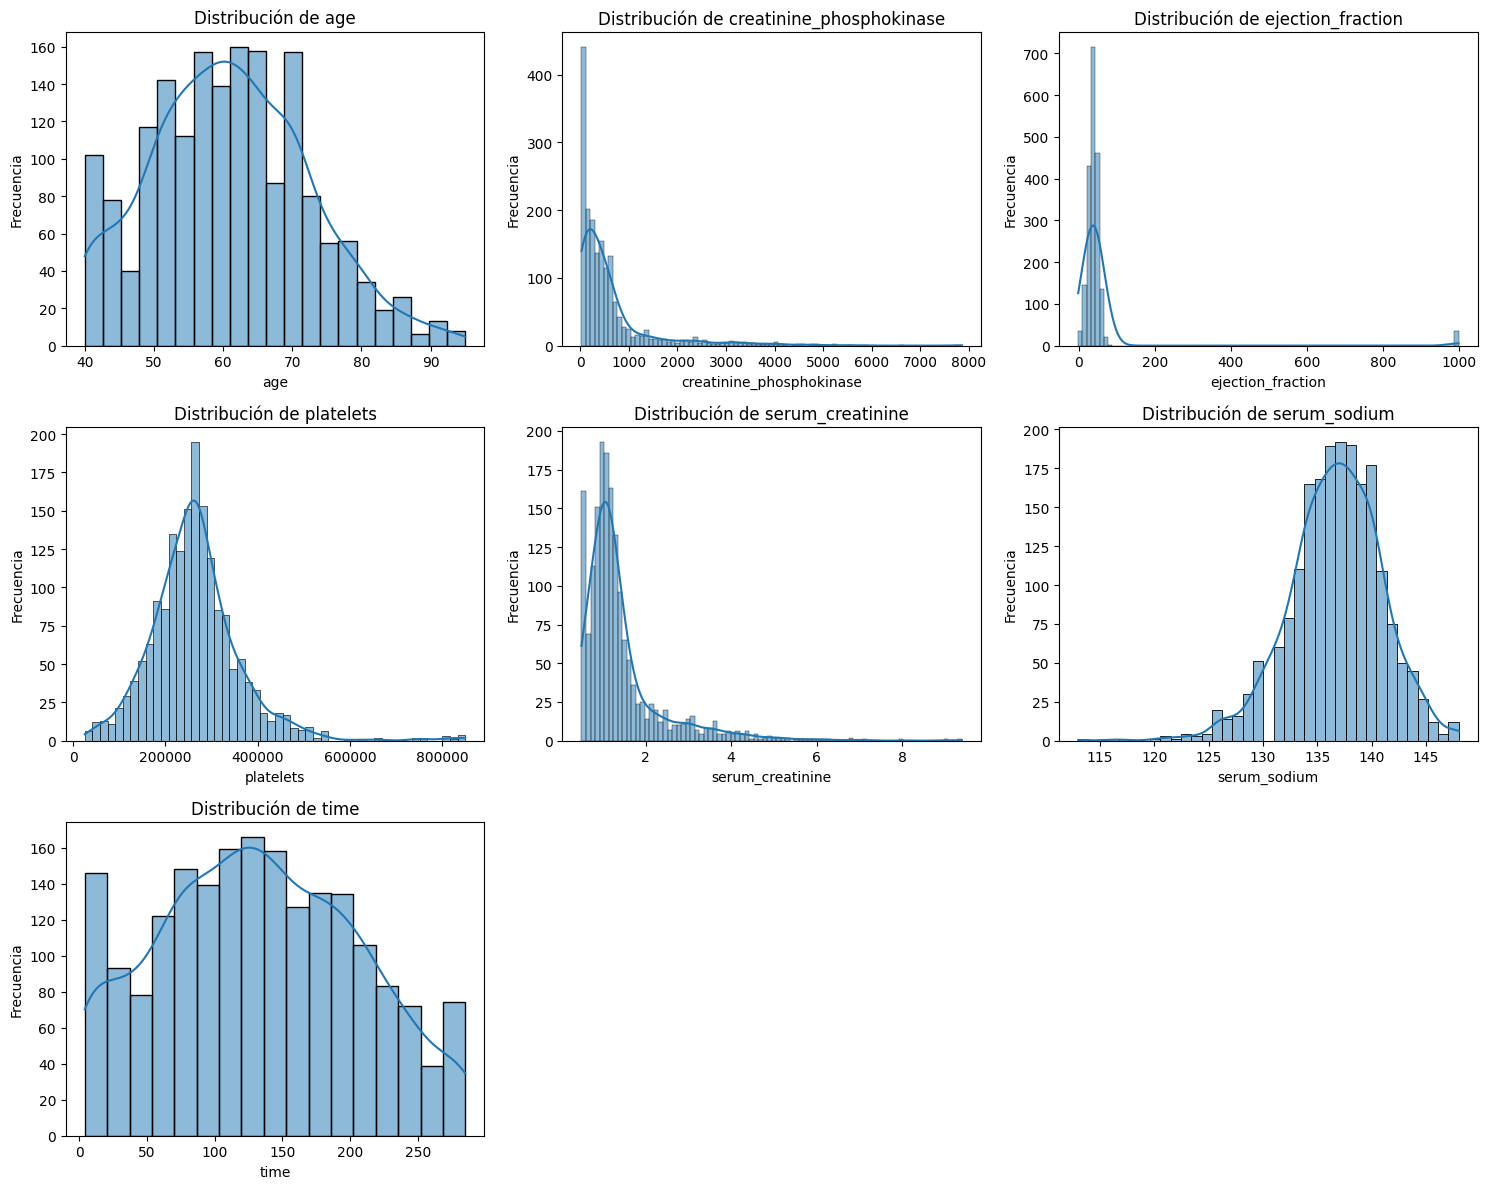

In [22]:
# Obtener columnas numéricas (excluyendo booleanas)
numeric_cols = df.select_dtypes(exclude=['boolean']).columns

# Calcular número de filas y columnas para el subplot
n_cols = 3
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

# Crear figura
plt.figure(figsize=(15, 4*n_rows))

# Crear subplots para cada variable
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(data=df, x=col, kde=True)
    plt.title(f'Distribución de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

### Se observan datos atipicos en ejection fraction 

In [23]:
# Se elimina los valores atípicos en ejection_fraction
df['ejection_fraction'] = df['ejection_fraction'].apply(lambda x: np.nan if x < 0 or x > 200 else x)

### Se procede a guardar el dataframe procesado

In [24]:
df.to_csv('heart_failure_clinical_records_extended_cleaned.csv', index=False)

### Se realizan múltiples gráficas para entender los datos

In [25]:
bins = [39, 45, 50, 55, 60, 65, 70, 75, 80, 95]
labels = ["40-45", "46-50", "51-55", "56-60", "61-65", "66-70", "71-75", "76-80", "81-95"]

d2_ = df.copy()

d2_['age_group'] = pd.cut(d2_['age'], bins=bins, labels=labels, right=True)

d2_[['age', 'age_group']].head()

,age,age_group
0,75.0,71-75
1,55.0,51-55
2,65.0,61-65
3,50.0,46-50
4,65.0,61-65


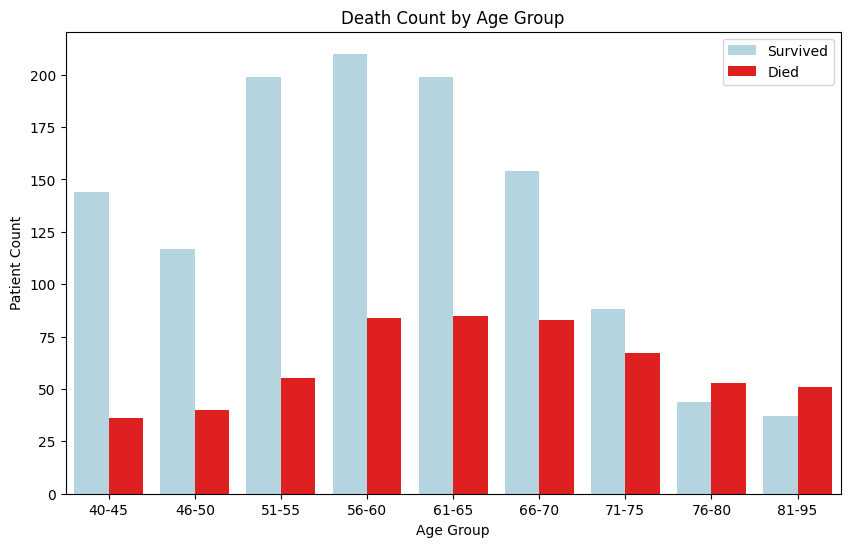

In [26]:
plt.figure(figsize=(10,6))
sns.countplot(data=d2_, x='age_group', hue='DEATH_EVENT', palette=["lightblue", "red"])
plt.title("Death Count by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Patient Count")
plt.legend(["Survived", "Died"])
plt.show()

### **Observación:** La gráfica muestra que, aunque los grupos de edad intermedios (ej. 51–65) concentran el mayor número absoluto de pacientes sobrevivientes, la proporción de fallecidos aumenta claramente en los grupos de mayor edad; especialmente 71–75 y 81–95 presentan tasas de mortalidad notablemente más altas que los grupos jóvenes; esto sugiere una relación positiva entre edad y riesgo de muerte durante el seguimiento.

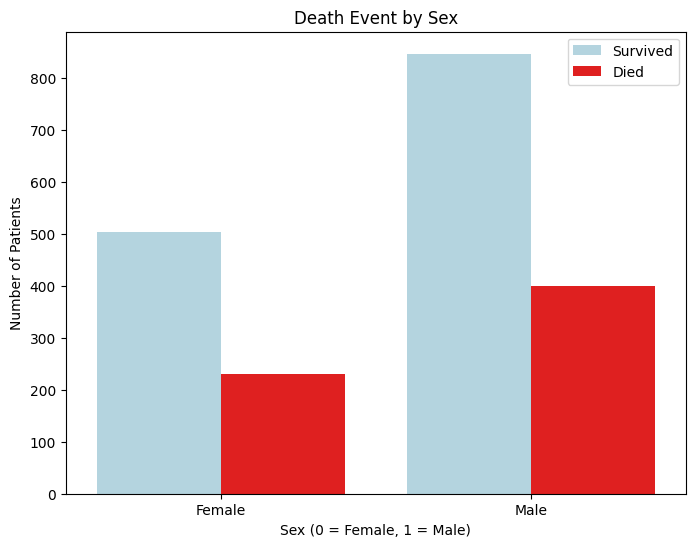

In [27]:
plt.figure(figsize=(8,6))
sns.countplot(data=df, x='sex', hue='DEATH_EVENT', palette=["lightblue", "red"])

plt.title("Death Event by Sex")
plt.xlabel("Sex (0 = Female, 1 = Male)")
plt.ylabel("Number of Patients")
plt.legend(["Survived", "Died"])
plt.xticks([0, 1], ["Female", "Male"])
plt.show()

### **Nota:** En la gráfica por sexo se observa que hay más pacientes hombres que mujeres y, en valores absolutos, también más muertes entre los hombres. No obstante, al mirar la proporción de fallecidos dentro de cada grupo, la diferencia parece menos contundente y podría ser pequeña, ya que el mayor número de muertes en hombres puede deberse en parte al mayor tamaño de esa submuestra. 

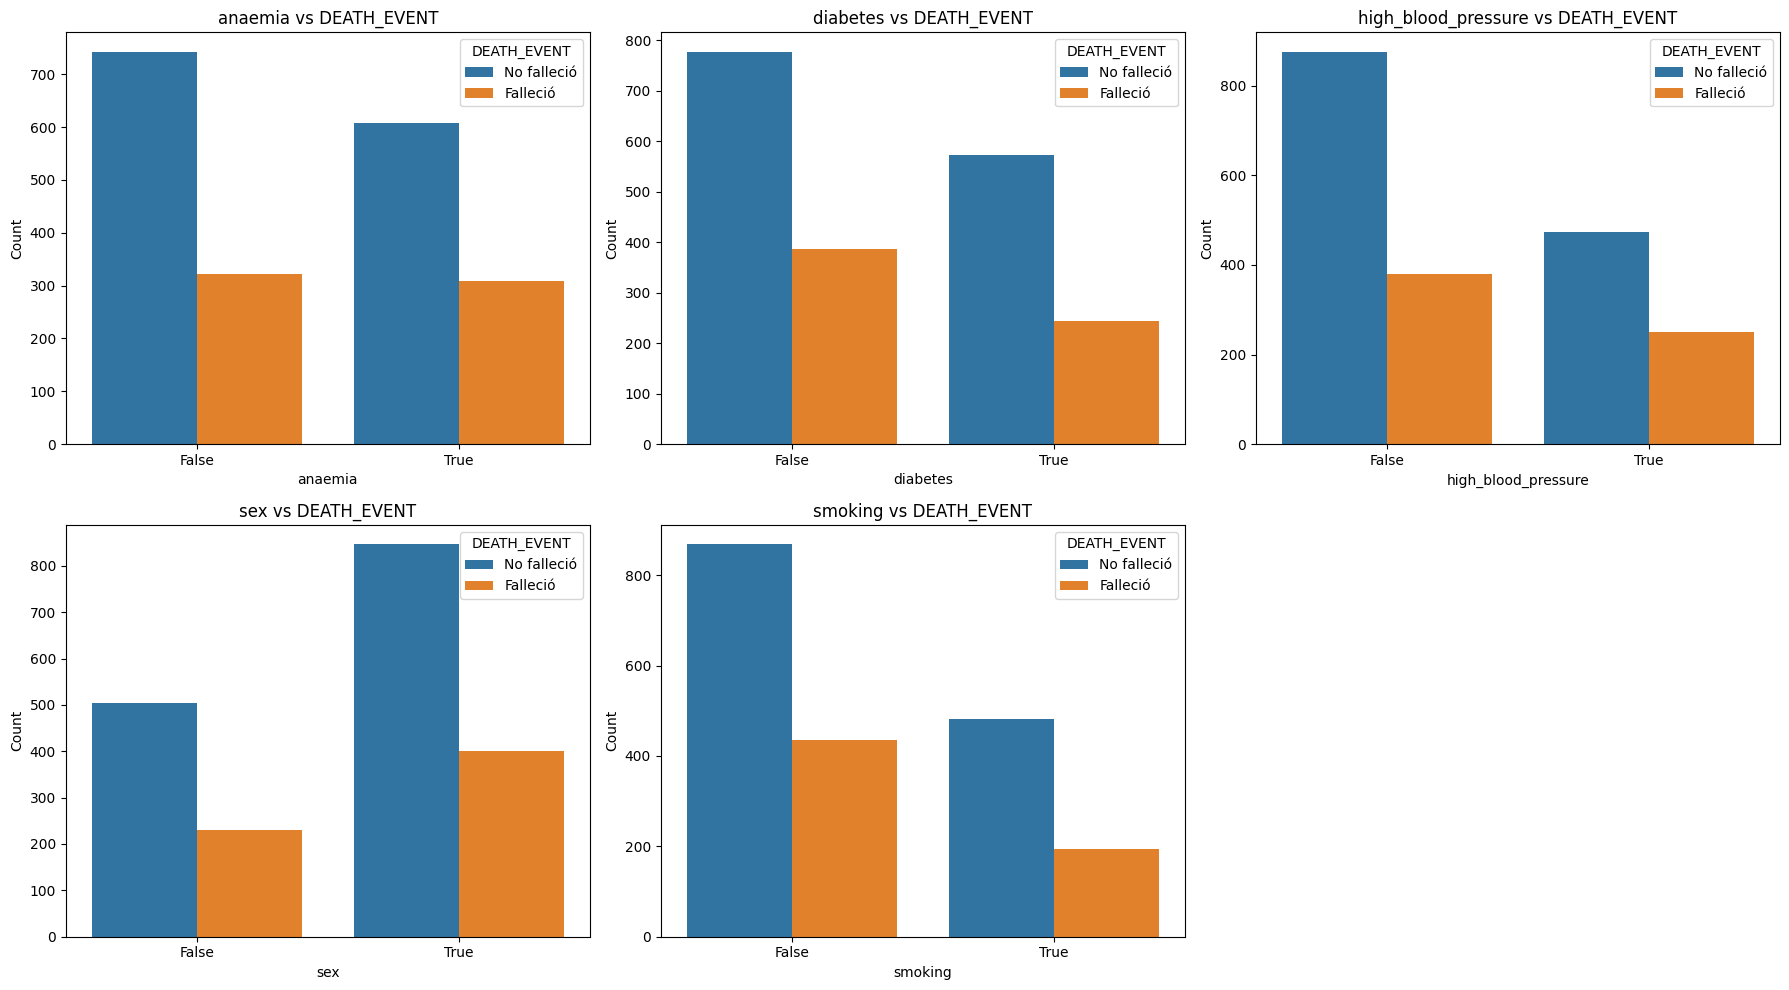

In [28]:
# Variables binarias que quieres comparar
binary_vars = ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']

# Crear subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()

# Graficar cada variable
for i, var in enumerate(binary_vars):
    sns.countplot(data=df, x=var, hue='DEATH_EVENT', ax=axes[i])
    axes[i].set_title(f'{var} vs DEATH_EVENT')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Count')
    axes[i].legend(title='DEATH_EVENT', labels=['No falleció', 'Falleció'])

# Eliminar subplot vacío si hay uno
if len(binary_vars) < len(axes):
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

``Anaemia``
- **Observación visual:** la barra roja (fallecidos) relativa al total del grupo parece más alta en pacientes con anaemia (True) que en los que no tienen anaemia (False).
- **Interpretación:** sugiere que la presencia de anemia está asociada a una mayor proporción de fallecimientos en el seguimiento. Clínicamente plausible: la anemia puede reflejar peor estado general o comorbilidades.
- **Señal:** moderada-fuerte visualmente (la diferencia de proporción es notable).

``Diabetes``
- **Observación visual:** también aquí la proporción de muertes parece mayor entre los diabéticos (True) que entre los no diabéticos.
- **Interpretación:** indica una asociación positiva entre diabetes y mortalidad. Podría reflejar mayor carga de comorbilidad o peor pronóstico.
- **Señal:** moderada; la diferencia es apreciable pero no tan grande como en algunos otros factores (según la gráfica).

``High_blood_pressure`` (hipertensión)
- **Observación visual:** se ve un mayor número absoluto de muertes en quienes tienen hipertensión (True) comparado con No, y la proporción de muertes dentro de «True» parece superior.
- **Interpretación:** hipertensión podría asociarse a mayor riesgo, aunque en muchos estudios su efecto depende de control, edad y otros factores cardiovasculares.
- **Señal:** moderada; comparable a diabetes/anaemia.

``Sex`` (sexo)
- **Observación visual:** hay muchos más hombres que mujeres en la muestra; en valores absolutos hay más muertes entre hombres (barra roja masculina mayor).
- **Interpretación:** el mayor número de muertes en hombres podría deberse a (a) mayor tamaño de la submuestra masculina o (b) un riesgo real mayor en hombres. Visualmente, la proporción no parece tan distinta como los conteos absolutos; por tanto la diferencia puede ser en gran parte por el mayor número de hombres.
- **Señal:** débil-moderada; necesita comparar proporciones (tasa de muerte por sexo) antes de concluir un efecto fuerte.

``Smoking`` (tabaquismo)
- **Observación visual:** los fumadores (True) muestran una proporción de fallecidos claramente mayor que los no fumadores.
- **Interpretación:** tabaquismo asociado a mayor mortalidad, coherente con efectos sobre enfermedad cardiovascular y comorbilidades.
- **Señal:** moderada-fuerte.

### Matriz de correlación

<Axes: >

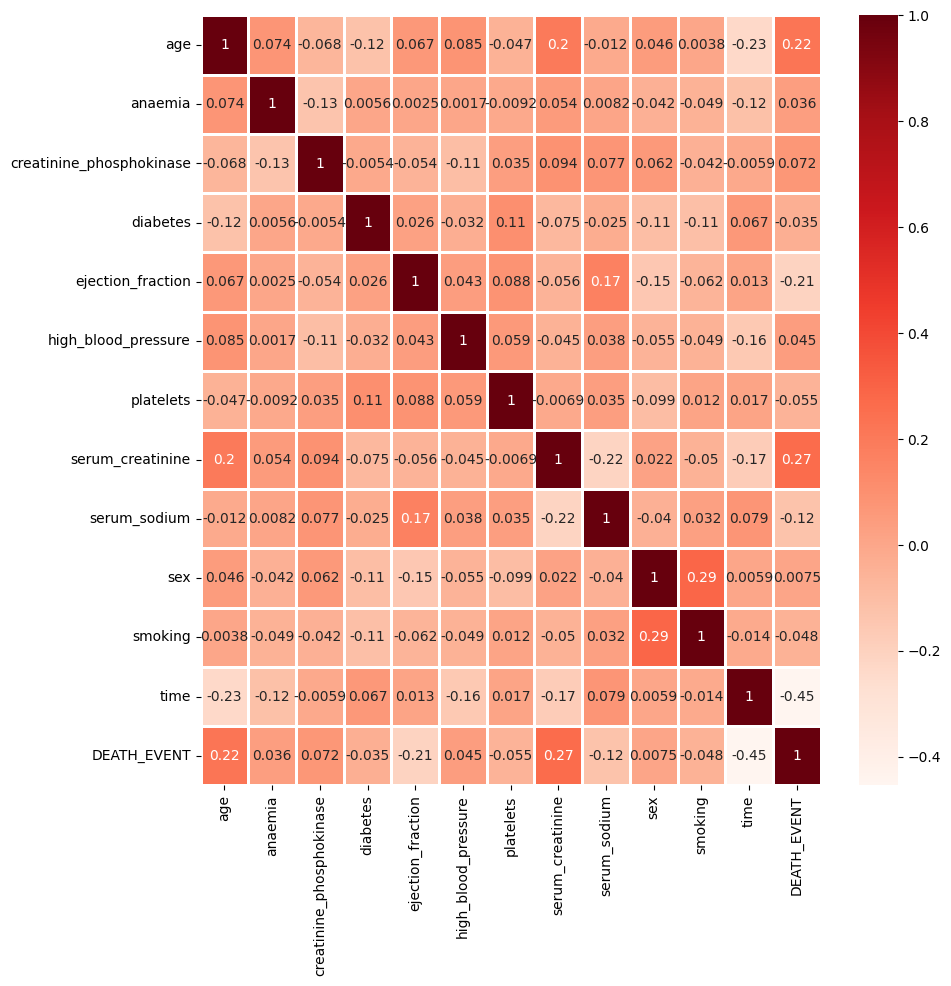

In [29]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(),cmap="Reds",annot=True,linewidth=1)

### **Observaciones:** La matriz muestra que las variables más asociadas con la muerte son serum_creatinine (r ≈ +0.26) y age (r ≈ +0.22), mientras que ``ejection_fraction`` presenta una correlación negativa relevante (r ≈ −0.21): es decir, mayor creatinina y edad y menor fracción de eyección se asocian con mayor probabilidad de ``DEATH_EVENT``. También destaca ``serum_sodium`` con correlación negativa moderada (≈ −0.13). Muchas de las variables binarias (anaemia, diabetes, hipertensión, ``smoking``, sex) tienen correlaciones pequeñas con ``DEATH_EVENT`` en términos de Pearson, aunque visualmente algunas muestran señales; además ``sex`` y ``smoking`` están moderadamente correlacionadas entre sí (≈ +0.29).